<a href="https://colab.research.google.com/github/ZacG1t/Lung_nodule_classification_LIDC/blob/main/UGRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [1]:
from collections import defaultdict
from zipfile import ZipFile

# Unzip LIDC file.
zip_path = '/content/drive/MyDrive/UGRP/LIDC.zip'
extract_path = '/content'
with ZipFile(zip_path, 'r') as zipObj:
  zipObj.extractall(extract_path)

In [2]:
!pip install "pydicom==2.4.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00


In [3]:
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import shutil
import pandas as pd

In [4]:
# Edit csv for easier analysis.

path = "/content/LIDC/LIDC-IDRI"
csv_path = '/content/LIDC/list3.2.csv'

list32 = pd.read_csv(csv_path, converters={'case': str, 'slice no.': str})
list32.sort_values(['case', 'slice no.'], ascending=True, inplace=True)
list32.head()

,case,scan,roi,volume,eq. diam.,x loc.,y loc.,slice no.,Unnamed: 8,nodIDs,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,0001,3000566,1,6459.75,23.107,317,367,43,NaN,IL057_127364,Nodule 001,MI014_12127,0,NaN,NaN,NaN
1,0002,3000522,1,6663.44,23.347,345,361,77,NaN,8,MI014_11691,NaN,NaN,NaN,NaN,NaN
3,0003,3000611,2,1165.82,13.058,221,219,56,NaN,IL057_130598,Nodule 002,9,MI014_16595,NaN,NaN,NaN
2,0003,3000611,1,408.79,9.208,308,198,57,NaN,Nodule 003,IL057_130602,8,MI014_16599,NaN,NaN,NaN
4,0003,3000611,3,4989.64,21.201,367,350,65,NaN,0,IL057_130591,Nodule 001,MI014_16588,NaN,NaN,NaN


In [5]:
def search_image(path):
    """Search and copy from LIDC to Dataset folder."""
    for root, dirs, files in os.walk(path):
        for i in range(len(list32)):
            if root[34:38] == list32['case'][i]:
                for file in files:
                    if file.endswith('.dcm'):
                        source = os.path.join(root, file)
                        ds = pydicom.dcmread(source)
                        patient_id = ds.PatientID
                        slice = ds.InstanceNumber
                        if int(file[2:-4]) == int(list32['slice no.'][i]):
                            try:
                                os.makedirs('/content/Dataset/Images_dcm/nodule')
                            except FileExistsError:
                                pass

                            destination = 'Temp'
                            shutil.copy(source, destination)

                            new_path = f"/content/Dataset/Images_dcm/nodule/{patient_id}-{slice}.dcm"
                            shutil.move(f"{destination}", new_path)

                        if int(file[2:-4]) != int(list32['slice no.'][i]):
                            try:
                                os.makedirs('/content/Dataset/Images_dcm/nonnodule')
                            except FileExistsError:
                                pass

                            source = os.path.join(root, file)
                            destination = 'Temp'
                            shutil.copy(source, destination)

                            new_path = f"/content/Dataset/Images_dcm/nonnodule/{patient_id}-{slice}.dcm"
                            shutil.move(f"{destination}", new_path)

In [6]:
path = '/content/LIDC/LIDC-IDRI/'

search_image(path)

In [7]:
def check_dup(nodule_path, nonnodule_path):
    """Check for duplicate files."""
    nod_path = nodule_path
    nonnod_path = nonnodule_path
    nod_list = os.listdir(nodule_path)
    nonnod_list = os.listdir(nonnodule_path)

    for file1 in nod_list:
        for file2 in nonnod_list:
            if file1 == file2:
                to_remove = os.path.join(nonnod_path, file2)
                os.remove(to_remove)

In [8]:
nodule_path = '/content/Dataset/Images_dcm/nodule'
nonnodule_path = '/content/Dataset/Images_dcm/nonnodule'

check_dup(nodule_path, nonnodule_path)

In [9]:
def segment_nod_image(path, file):
    """Use list of files from search_image to perform segmentation."""
    ds = pydicom.dcmread(os.path.join(path, file))
    patient_id = ds.PatientID
    slice = ds.InstanceNumber
    pixel_array = ds.pixel_array
    intercept = ds.RescaleIntercept
    slope = ds.RescaleSlope

    # Convert to HU value.
    hu_image = pixel_array * slope + intercept

    # Apply threshold.
    lower_hu = -900
    upper_hu = -200
    lung_mask = np.logical_and(hu_image >= lower_hu, hu_image <= upper_hu).astype(np.uint8) * 255

    # Find lung contours.
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    refined_mask = np.zeros_like(lung_mask)
    cv2.drawContours(refined_mask, sorted_contours, -1, 255, thickness=cv2.FILLED)

    # Multiply lung image with mask.
    segmented_lung = np.zeros_like(hu_image)
    segmented_lung[refined_mask == 255] = hu_image[refined_mask == 255]

    os.makedirs('/content/Dataset/segmented_image/nodule', exist_ok=True)

    np.save(f"/content/Dataset/segmented_image/nodule/{patient_id}-{slice}.npy", segmented_lung)

In [10]:
def segment_nonnod_image(path, file):
    """Use list of files from search_image to perform segmentation."""
    ds = pydicom.dcmread(os.path.join(path, file))
    patient_id = ds.PatientID
    slice = ds.InstanceNumber
    pixel_array = ds.pixel_array
    intercept = ds.RescaleIntercept
    slope = ds.RescaleSlope

    # Convert to HU value.
    hu_image = pixel_array * slope + intercept

    # Apply threshold.
    lower_hu = -900
    upper_hu = -200
    lung_mask = np.logical_and(hu_image >= lower_hu, hu_image <= upper_hu).astype(np.uint8) * 255

    # Find lung contours.
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    refined_mask = np.zeros_like(lung_mask)
    cv2.drawContours(refined_mask, sorted_contours, -1, 255, thickness=cv2.FILLED)

    # Multiply lung image with mask.
    segmented_lung = np.zeros_like(hu_image)
    segmented_lung[refined_mask == 255] = hu_image[refined_mask == 255]

    os.makedirs('/content/Dataset/segmented_image/nonnodule', exist_ok=True)

    np.save(f"/content/Dataset/segmented_image/nonnodule/{patient_id}-{slice}.npy", segmented_lung)

In [11]:
# Segment images.
nod_path = '/content/Dataset/Images_dcm/nodule'
nonnod_path = '/content/Dataset/Images_dcm/nonnodule'

for file in os.listdir(nod_path):
    segment_nod_image(nod_path, file)

for file in os.listdir(nonnod_path):
    segment_nonnod_image(nonnod_path, file)

In [12]:
# Count num of images with nodules.
from collections import defaultdict

segmented_path = '/content/Dataset/segmented_image/nodule'

img_files = [f for f in os.listdir(segmented_path)]

dimension_counts = defaultdict(int)

# Put all files into a list.
for file in img_files:
    pixel_array = np.load(os.path.join(segmented_path, file))
    dimensions = pixel_array.shape
    dimension_counts[dimensions] += 1

# Check dimension of all images.
print("Image with Nodule Counts:")
Total = 0
for dimensions, count in dimension_counts.items():
    print(f"Dimensions: {dimensions}, Count: {count}")
    Total += count
print(f"Total images = {Total}")

Image with Nodule Counts:
Dimensions: (512, 512), Count: 188
Total images = 188


In [13]:
# Count num of images without nodules.
from collections import defaultdict

segmented_path = '/content/Dataset/segmented_image/nonnodule'

img_files = [f for f in os.listdir(segmented_path)]

dimension_counts = defaultdict(int)

# Put all files into a list.
for file in img_files:
    pixel_array = np.load(os.path.join(segmented_path, file))
    dimensions = pixel_array.shape
    dimension_counts[dimensions] += 1

# Check dimension of all images.
print("Image without Nodule Counts:")
Total = 0
for dimensions, count in dimension_counts.items():
    print(f"Dimensions: {dimensions}, Count: {count}")
    Total += count
print(f"Total images = {Total}")

Image without Nodule Counts:
Dimensions: (512, 512), Count: 9774
Total images = 9774


# Labelling.

In [14]:
nodule_path = '/content/Dataset/segmented_image/nodule'
nonnodule_path = '/content/Dataset/segmented_image/nonnodule'

nodule_list = [f for f in os.listdir(nodule_path)]
nonnodule_list = [f for f in os.listdir(nonnodule_path)]
all_list = nodule_list + nonnodule_list

nodule_path_list = [os.path.join(nodule_path, f) for f in os.listdir(nodule_path)]
nonnodule_path_list = [os.path.join(nonnodule_path, f) for f in os.listdir(nonnodule_path)]
all_path_list = nodule_path_list + nonnodule_path_list

filename = []
status = []

for f in all_list:
    if f.endswith('.npy'):
        if f in nodule_list:
            name = os.path.join(nodule_path, f)
            filename.append(name)
            status.append(1)
        if f in nonnodule_list:
            name = os.path.join(nonnodule_path, f)
            filename.append(name)
            status.append(0)

labels = {
    'filename': filename,
    'class': status
}

# Training.

In [15]:
# Custom data generator.
import numpy as np
import tensorflow as tf
import cv2

class MedicalImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(224, 224), shuffle=True, augment=False, **kwargs):
        super().__init__(**kwargs)

        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        batch_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        images = self.__load_images(batch_paths)
        return images, np.array(batch_labels)

    def __load_images(self, batch_paths):
        batch_images = []
        for path in batch_paths:
            img = np.load(path)  # Load .npy image
            img = cv2.resize(img, self.target_size)  # Resize

            # Ensure correct shape
            if len(img.shape) == 2:  # Grayscale (H, W)
                img = np.stack([img]*3, axis=-1)  # Convert to (H, W, 3)

            img = img / 255.0  # Normalize
            batch_images.append(img)

        return np.array(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [16]:
# Data splitting.
from sklearn.model_selection import train_test_split

# Assume image paths are stored as a list (update with actual file paths)
image_paths = [f for f in all_path_list]

# Load corresponding labels
labels = {}
for file in all_list:
    if file in nodule_list:
        labels[file] = 1
    if file in nonnodule_list:
        labels[file] = 0
labels_list = list(labels.values())

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels_list, test_size=0.2, random_state=42)

# Create Data Generators
train_generator = MedicalImageGenerator(train_paths, train_labels, batch_size=8, augment=True)
val_generator = MedicalImageGenerator(val_paths, val_labels, batch_size=8, augment=False)


In [18]:
# Training.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load Pretrained ResNet50 Model.
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add Custom Layers.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(np.unique(labels)), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile Model.
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the Model with Custom Generator.
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 133s 123ms/step - accuracy: 0.9753 - loss: 0.1418 - val_accuracy: 0.9784 - val_loss: 0.1062
Epoch 2/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 112s 113ms/step - accuracy: 0.9808 - loss: 0.1025 - val_accuracy: 0.9784 - val_loss: 0.0992
Epoch 3/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 115s 115ms/step - accuracy: 0.9836 - loss: 0.0862 - val_accuracy: 0.9784 - val_loss: 0.0992
Epoch 4/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 116s 116ms/step - accuracy: 0.9791 - loss: 0.1055 - val_accuracy: 0.9784 - val_loss: 0.0999
Epoch 5/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 116s 117ms/step - accuracy: 0.9826 - loss: 0.0904 - val_accuracy: 0.9784 - val_loss: 0.0977
Epoch 6/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 114s 115ms/step - accuracy: 0.9795 - loss: 0.0956 - val_accuracy: 0.9784 - val_loss: 0.0978
Epoch 7/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 117s 117ms/step - accuracy: 0.9805 - loss: 0.0914 - val_accuracy: 0.9784 - val_loss: 0.1020
Epoch 8/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 116s 117ms/step - accuracy: 0.9809 -

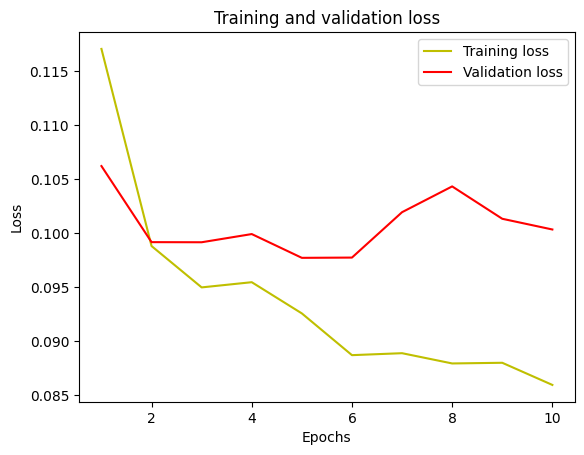

In [19]:
# Plot the training and validation loss at each epoch.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()